#EDA of Dataset
We are using a Kaggle dataset of Twitter financial news. This is an annotated corpus of finance-related tweets and contains 21,107 records with 20 unique labels that classify their topic. According to Kaggle, this data was collected using a Twitter API. The training dataset provided contains 16,990 records and the validation set contains 4,118. We will be treating the validation set as our test set and creating another validation set from the training dataset provided.

In [ ]:
!pip install -q transformers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from transformers import AutoTokenizer
from nltk.tokenize import TweetTokenizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.8 MB/s eta 0:00:00


####Loading Training Dataset

In [ ]:
raw_train_data = pd.read_csv('/content/train_data.csv')

In [ ]:
print('Training Set:')
raw_train_data.info()

Training Set:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16990 entries, 0 to 16989
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16990 non-null  object
 1   label   16990 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 265.6+ KB


In [ ]:
raw_train_data.head(5)

,text,label
0,Here are Thursday's biggest analyst calls: App...,0
1,Buy Las Vegas Sands as travel to Singapore bui...,0
2,"Piper Sandler downgrades DocuSign to sell, cit...",0
3,"Analysts react to Tesla's latest earnings, bre...",0
4,Netflix and its peers are set for a ‘return to...,0


####Understanding Labels

The labels are encoded and represent the following:

    "LABEL_0": "Analyst Update",

    "LABEL_1": "Fed | Central Banks",

    "LABEL_2": "Company | Product News",

    "LABEL_3": "Treasuries | Corporate Debt",

    "LABEL_4": "Dividend",

    "LABEL_5": "Earnings",

    "LABEL_6": "Energy | Oil",

    "LABEL_7": "Financials",

    "LABEL_8": "Currencies",

    "LABEL_9": "General News | Opinion",

    "LABEL_10": "Gold | Metals | Materials",

    "LABEL_11": "IPO",

    "LABEL_12": "Legal | Regulation",

    "LABEL_13": "M&A | Investments",

    "LABEL_14": "Macro",

    "LABEL_15": "Markets",

    "LABEL_16": "Politics",

    "LABEL_17": "Personnel Change",

    "LABEL_18": "Stock Commentary",

    "LABEL_19": "Stock Movement"

In [ ]:
labels = ["Analyst Update","Fed | Central Banks",
        "Company | Product News","Treasuries | Corporate Debt",
        "Dividend","Earnings","Energy | Oil",
        "Financials","Currencies","General News | Opinion",
        "Gold | Metals | Materials","IPO","Legal | Regulation",
        "M&A | Investments","Macro","Markets","Politics",
        "Personnel Change","Stock Commentary", "Stock Movement"]

In [ ]:
train_labels = raw_train_data['label']
train_text = raw_train_data['text']

print('Training Set of Labels:')
print(train_labels.head(5))
print('\n')
print('Training Set of Text:')
print(train_text.head(5))

Training Set of Labels:
0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64


Training Set of Text:
0    Here are Thursday's biggest analyst calls: App...
1    Buy Las Vegas Sands as travel to Singapore bui...
2    Piper Sandler downgrades DocuSign to sell, cit...
3    Analysts react to Tesla's latest earnings, bre...
4    Netflix and its peers are set for a ‘return to...
Name: text, dtype: object


In [ ]:
train_text[:2]

0    Here are Thursday's biggest analyst calls: App...
1    Buy Las Vegas Sands as travel to Singapore bui...
Name: text, dtype: object

In [ ]:
#these are tweets so they have a max character value of 250?
#But there could be variation in length. 94, 92, 104, 126

#print(len(train_text[1]))

lengths = []

for text in train_text:
  length=len(text)
  lengths.append(length)

print(lengths)
print(max(lengths)) #316 - Need to look at this.
print(min(lengths)) #2 - also need to look at this.
print()

[126, 92, 109, 113, 123, 109, 98, 123, 89, 123, 126, 109, 126, 130, 92, 103, 111, 116, 101, 220, 104, 114, 126, 107, 109, 109, 113, 101, 278, 129, 124, 122, 120, 124, 86, 126, 124, 100, 112, 111, 101, 123, 118, 112, 279, 87, 117, 92, 119, 110, 104, 117, 116, 121, 102, 117, 108, 265, 127, 120, 109, 122, 89, 162, 127, 137, 94, 86, 51, 85, 195, 116, 139, 153, 101, 127, 151, 189, 175, 103, 114, 109, 149, 93, 135, 93, 89, 105, 108, 118, 223, 258, 105, 117, 129, 117, 93, 113, 113, 107, 95, 98, 85, 113, 119, 115, 118, 111, 109, 94, 100, 118, 118, 115, 133, 110, 112, 124, 113, 125, 97, 110, 93, 116, 81, 111, 138, 96, 112, 112, 118, 110, 114, 159, 88, 112, 147, 130, 109, 124, 119, 123, 128, 148, 120, 71, 130, 120, 111, 111, 105, 134, 110, 100, 121, 85, 104, 85, 93, 83, 125, 120, 107, 118, 97, 100, 105, 118, 79, 87, 127, 99, 87, 115, 119, 112, 107, 86, 94, 109, 140, 93, 92, 128, 111, 108, 111, 102, 99, 100, 110, 108, 101, 87, 124, 116, 106, 100, 64, 103, 116, 104, 119, 82, 95, 98, 209, 118, 67, 

In [ ]:
for text in train_text:
  if len(text) <= 10:
    print(text)

# These are stock abbreviations?

$ASML
$TSLA
$CLDX $VMW
$LTBR $AIR
$ADCT $NGS
$UEC $ABBV
$ICL $RDWR
$DIN $BLNK
$TTE $GE
$B $KTOS
$DBI $SHCR
$SIDU push
$378P
$T
$AAPL
$MRNA
$OXY
$PLRX 21


In [ ]:
for text in train_text:
  if len(text) >= 316:
    print(text)

#Did notice that & is coming up as '&amp' that could throw off our character count.
#In playing with the values some tweets have emojis in them. how do you want to handle this?

@bennpeifert One theme of "A History of U.S. in Five Crashes" is every modern crash is fueled by a financial contraption which injects financial leverage into system which is on edge.  1907 - Saving trusts 1929 - Investment trusts 1987 - Port. insurance 2008 - MBS 2010 - Algorithmic trading  https://t.co/gVcrGh50cV


In [ ]:
def preview_random_sample(df, sample_num = 5):
    # A function to grab a random sample and display the text and associated labels

    # VARIABLES
    # df = dataframe
    # col_name = name of column to display
    # sample_num = number of samples to display

    # generating random sample
    random_sample = df.sample(sample_num)

    # looping over sample an displaying results
    for i, data in enumerate(random_sample.iterrows()):
        print(f'RECORD {i+1}')
        print(f'Text: {data[1].text}')
        print(f'Label: {labels[data[1].label]}\n')

    return 'SAMPLING COMPLETE'

In [ ]:
preview_random_sample(raw_train_data, sample_num=5)

RECORD 1
Text: Amazon Prime Day: 7 ‘greener’ ways to shop the deals, including plastic-free packaging  https://t.co/SEAlO5AaIO
Label: Company | Product News

RECORD 2
Text: Biden meet with Palestinian President Mahmoud Abbas during his visit to the Middle East, and pledged to bring the Palestinians and Israelis sides together  https://t.co/o1fSzOhbw1  https://t.co/2T5upfDwgr
Label: Politics

RECORD 3
Text: $TWLO - Twilio Q2: Still Priced At A Steep Premium.  https://t.co/7U2x377uYZ #trading #markets #stocks
Label: Stock Commentary

RECORD 4
Text: $LPSN (+1.3% pre) LivePerson (LPSN) Enters Agreement with Starboard Value - SI   https://t.co/la1c4d9Mo7
Label: Stock Movement

RECORD 5
Text: Nasdaq short interest slips 0.4% in late June  https://t.co/p6RhcNqGbl  https://t.co/diKc7p6TDK
Label: Markets



'SAMPLING COMPLETE'

A sample set has returned the use of Emojis. We have concluded that Emojis are of no concern for this task, as the tokenizer of the model is capable of processing them effectively. However, we need to remove the links.

In [ ]:
label_count = train_labels.value_counts()
label_count

2     3545
18    2118
14    1822
9     1557
5      987
16     985
1      837
19     823
7      624
6      524
15     501
17     495
12     487
13     471
4      359
3      321
0      255
8      166
10      69
11      44
Name: label, dtype: int64

In [ ]:
label_map = {
    0: "Analyst Update",
    1: "Fed | Central Banks",
    2: "Company | Product News",
    3: "Treasuries | Corporate Debt",
    4: "Dividend",
    5: "Earnings",
    6: "Energy | Oil",
    7: "Financials",
    8: "Currencies",
    9: "General News | Opinion",
    10: "Gold | Metals | Materials",
    11: "IPO",
    12: "Legal | Regulation",
    13: "M&A | Investments",
    14: "Macro",
    15: "Markets",
    16: "Politics",
    17: "Personnel Change",
    18: "Stock Commentary",
    19: "Stock Movement"
    }

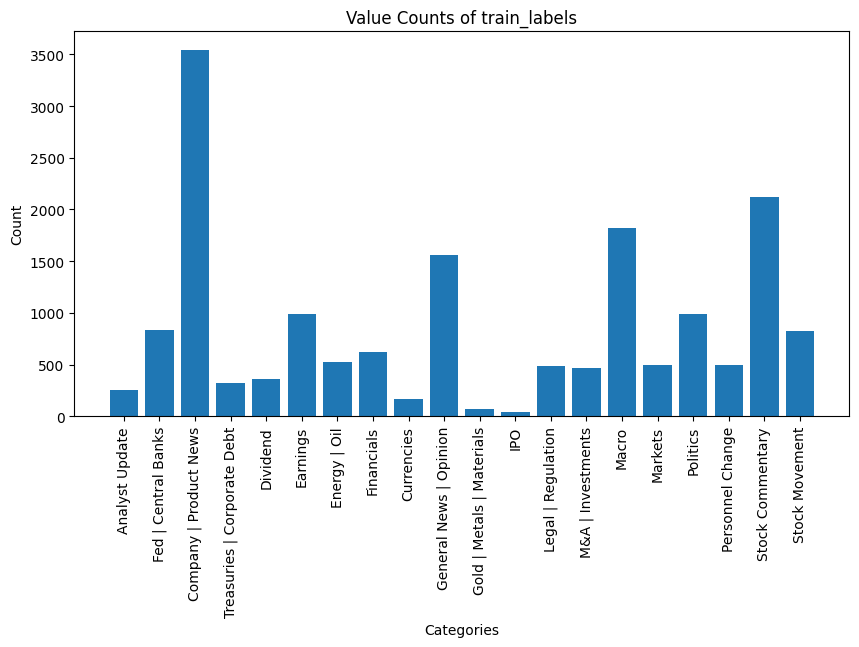

In [ ]:
plt.figure(figsize=(10, 5))
plt.bar(label_count.index, label_count.values)
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Value Counts of train_labels')

# Set x-axis ticks to label names
tick_positions = list(label_map.keys())
tick_labels = list(label_map.values())
plt.xticks(tick_positions, tick_labels, rotation=90)

plt.show()

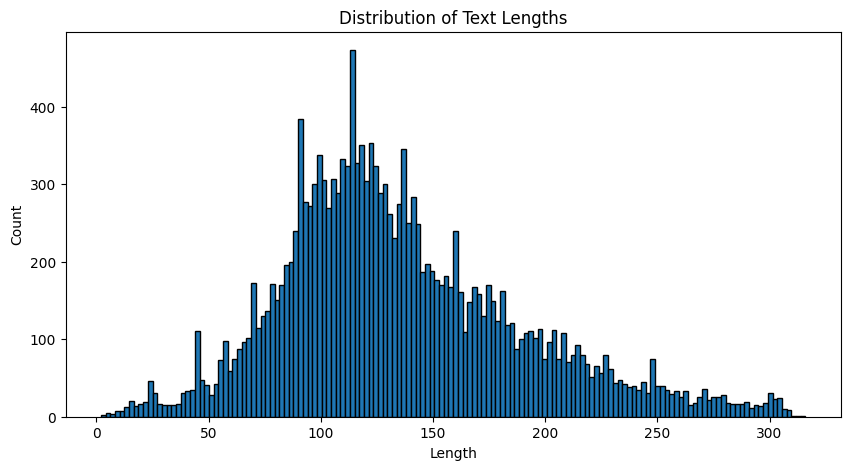

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(lengths, bins=150, edgecolor='black')
plt.xlabel('Length')
plt.ylabel('Count')
plt.title('Distribution of Text Lengths')

plt.show()

Labels are unbalanced and tweet length varies greatly. Links should be removed and possibly replaced with the word "LINK" in the event that they have some value.

Should we account for the unbalanced label data?

##Emojis and Tokens

In [ ]:
#find all the emojis
emoji_pattern = re.compile(r"[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251\U0001F004\U0001F0CF\U0001F170-\U0001F171\U0001F17E-\U0001F17F\U0001F18E\U0001F191-\U0001F19A\U0001F1E6-\U0001F1FF]", flags=re.UNICODE)

In [ ]:
emojis_found = set()  # Use a set to avoid duplicate emojis; only care about unique.

for text in train_text:
    emojis = emoji_pattern.findall(text)
    emojis_found.update(emojis)

In [ ]:
from pandas.core.api import value_counts

emojis_found_count = value_counts(emojis_found)
emojis_found_count

{🥇, 🇩, 🇳, 🇱, 🤣, 🚀, 🎯, 🔽, 🌭, 🏛, 🤯, 🏻, 🎙, 🇮, 🚨, 🔹, 💵, 🇧, 🙅, 🤦, ❤, 🇪, 🇹, 🎉, 👇, 😈, 🚢, 💨, 🇰, 😉, 📌, 🐐, 👉, 🥲, 😂, 🔵, 🤔, 🐠, 🚪, ⤵, 👋, 🔥, 👍, 😍, ✈, 💚, 📈, 📽, 🚗, 🎧, 🥤, ⚓, 🔔, ♂, ⬆, 🏡, 🙏, 👀, 💸, 📉, 🔋, 💙, ⚡, ⬇, ✨, 🤪, ▶, 🧵, 😴, 💶, 🌊, 🇬, 💥, 🌳, 😅, 🇯, ️, 🟢, 🇨, 🔭, 📻, 🗣, 🇷}    83
dtype: int64

In [ ]:
!pip install -q transformers
from transformers import AutoTokenizer

####Bert Base Tonkenizer - Emojis

In [ ]:
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
bert_tokens = [] #Returns UNK tokens for emojis in text.

for emoji in emojis_found:
    print(bert_tokenizer.tokenize(emoji))
    bert_tokens.append(bert_tokenizer.tokenize(emoji))

####FinBert Tokenizer - Emojis

In [ ]:
fin_tokenizer = AutoTokenizer.from_pretrained('yiyanghkust/finbert-pretrain')

finbert_tokens = [] #also creates unk tokens for emojis in text

for emoji in emojis_found:
    print(fin_tokenizer.tokenize(emoji))
    finbert_tokens.append(fin_tokenizer.tokenize(emoji))

#### NLTK Tweet Tokenizer - Emojis

In [ ]:
tweet_tokenizer = TweetTokenizer()

tweet_tokens = [] #works on emojis

for emoji in emojis_found:
    print(tweet_tokenizer.tokenize(emoji))
    tweet_tokens.append(tweet_tokenizer.tokenize(emoji))

['🥇']
['🇩']
['🇳']
['🇱']
['🤣']
['🚀']
['🎯']
['🔽']
['🌭']
['🏛']
['🤯']
['🏻']
['🎙']
['🇮']
['🚨']
['🔹']
['💵']
['🇧']
['🙅']
['🤦']
['❤']
['🇪']
['🇹']
['🎉']
['👇']
['😈']
['🚢']
['💨']
['🇰']
['😉']
['📌']
['🐐']
['👉']
['🥲']
['😂']
['🔵']
['🤔']
['🐠']
['🚪']
['⤵']
['👋']
['🔥']
['👍']
['😍']
['✈']
['💚']
['📈']
['📽']
['🚗']
['🎧']
['🥤']
['⚓']
['🔔']
['♂']
['⬆']
['🏡']
['🙏']
['👀']
['💸']
['📉']
['🔋']
['💙']
['⚡']
['⬇']
['✨']
['🤪']
['▶']
['🧵']
['😴']
['💶']
['🌊']
['🇬']
['💥']
['🌳']
['😅']
['🇯']
['️']
['🟢']
['🇨']
['🔭']
['📻']
['🗣']
['🇷']


In [ ]:
import json

In [ ]:
with open("tweet_emoji_tokens.json", "w") as file:
    json.dump(tweet_tokens, file)

##Hashtags

In [ ]:
# Define the regular expression pattern for hashtags
hashtag_pattern = r"#\w+"

    # Use re.findall to find all occurrences of the pattern in the text
    #hashtags = re.findall(hashtag_pattern, text)



In [ ]:
hashtag_pattern = r"#\w+"

hashtags_found = set()  # Use a set to avoid duplicate emojis; only care about unique.

for index, text in train_text.iteritems():
    # Check if the element is a string
    if not isinstance(text, str):
        # Handle cases where elements in train_text are not strings
        continue

    hashtags = re.findall(hashtag_pattern, text)
    hashtags_found.update(hashtags)

<ipython-input-34-73cee32f148b>:5: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, text in train_text.iteritems():


In [ ]:
#Hashtags to be explored on further iterations.

In [ ]:
hashtags_found

In [ ]:
hash_bert_tokens = []

for hash in hashtags_found:
    print(bert_tokenizer.tokenize(hash))
    hash_bert_tokens.append(bert_tokenizer.tokenize(hash))

In [ ]:
hash_fin_tokens = []

for hash in hashtags_found:
    print(fin_tokenizer.tokenize(hash))
    hash_fin_tokens.append(fin_tokenizer.tokenize(hash))

In [ ]:
hash_tweet_tokens = []

for hash in hashtags_found:
    print(tweet_tokenizer.tokenize(hash))
    hash_tweet_tokens.append(tweet_tokenizer.tokenize(hash))